## Overview

This is the note that I took when learning [this lecture](https://learn.deeplearning.ai/courses/preprocessing-unstructured-data-for-llm-applications) from DeepLearning.AI.

I made a lot effort to organise everything in the lecture, into a single, coherent document. I hope this helps you.

This notebook talked about.

- Processing documents:
    - content
    - elements: title, narritive, table, image
    - metadata: page number, file type, file name
- RAG: retrieve context from database and inject this to the prompt for an LLM

## Normalising Content

```{mermaid}
flowchart LR
    H[HTML];
    P[PDF];
    S[PPTX];
    U([Unstructured API]);
    H --> U;
    S --> U;
    P --> U;
    U --> JSON;
```

We want to convert raw documents to a common format, so LLMs treat everything in the same way.

We will then perform **data serialisation** to stored the pre--processed content. (In this course we will use json.)


In [1]:
import os
import json
from pprint import pprint
import warnings; warnings.filterwarnings('ignore')  # noqa

from IPython.display import Image
from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError

from unstructured.partition.html import partition_html
from unstructured.partition.pptx import partition_pptx
from unstructured.staging.base import dict_to_elements, elements_to_json

### Process HTML (local)

The HTML page we are going to process looks like the image blow.

There are images, titles, and other web elements.

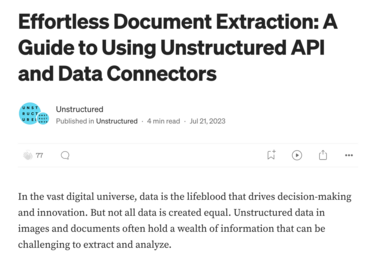

In [3]:
Image(filename="images/HTML_demo.png", width=250)

We use the [partition_html](https://docs.unstructured.io/open-source/core-functionality/partitioning#partition-html) function to process the html file.

We get a `list` of [unstructured elements](https://docs.unstructured.io/open-source/concepts/document-elements) back.

In [4]:
filename = "example_files/medium_blog.html"
elements = partition_html(filename=filename)

element_types = set([type(e) for e in elements])

pprint({
    "number": len(elements),
    "types": element_types,
})

{'number': 72,
 'types': {<class 'unstructured.documents.elements.NarrativeText'>,
           <class 'unstructured.documents.elements.ListItem'>,
           <class 'unstructured.documents.elements.Title'>,
           <class 'unstructured.documents.elements.Text'>}}


We can use the `to_dict` method to get the information / resource for each element!

In [5]:
pprint(elements[0].to_dict(), width=60, depth=2)

{'element_id': '58ce54f95c4ba051d7ba46498beed83d',
 'metadata': {'category_depth': 0,
              'file_directory': 'example_files',
              'filename': 'medium_blog.html',
              'filetype': 'text/html',
              'languages': [...],
              'last_modified': '2024-08-28T09:58:39',
              'link_texts': [...],
              'link_urls': [...]},
 'text': 'Open in app',
 'type': 'Title'}


### Parsing Power Points (local)

We can parse the power point slides with [partition_pptx](https://docs.unstructured.io/open-source/core-functionality/partitioning#partition-pptx).

The slides to be ingested looks like below.

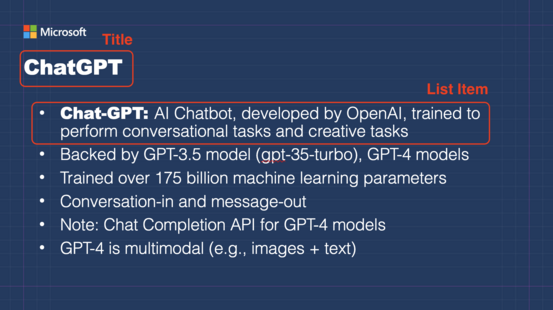

In [6]:
Image(filename="images/pptx_slide.png", width=300)

In [7]:
filename = "example_files/msft_openai.pptx"
elements = partition_pptx(filename=filename)

element_types = set([type(e) for e in elements])

print("Elements Information")
pprint({
    "number": len(elements),
    "types": element_types,
})

print("\nElement #1 content")
pprint(elements[0].to_dict(), width=60, depth=2)

Elements Information
{'number': 7,
 'types': {<class 'unstructured.documents.elements.ListItem'>,
           <class 'unstructured.documents.elements.Title'>}}

Element #1 content
{'element_id': 'e53cb06805f45fa23fb6d77966c5ec63',
 'metadata': {'category_depth': 1,
              'file_directory': 'example_files',
              'filename': 'msft_openai.pptx',
              'filetype': 'application/vnd.openxmlformats-officedocument.presentationml.presentation',
              'languages': [...],
              'last_modified': '2024-08-28T09:58:40',
              'page_number': 1},
 'text': 'ChatGPT',
 'type': 'Title'}


### Parsing PDF (API)

We can parse PDF files using [partition_pdf](https://docs.unstructured.io/open-source/core-functionality/partitioning#partition-pdf), like the previous examples.

However, we are doing something different this time. We will use the [Python SDK of the unstructured API](https://docs.unstructured.io/api-reference/api-services/sdk-python).

In this example, we will use [unstructured API](https://docs.unstructured.io/api-reference/api-services/saas-api-development-guide), sending the PDF to the cloud to process.

This is the how the data looks like

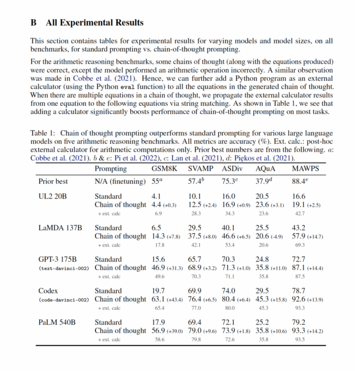

In [9]:
Image(filename="images/cot_paper.png", width=250) 

To use the API, we need to connect to the unstructured service.

We can get a free unstructured API key at the moment (~2024).

In this example, I stored the API key in the enviromental variable `TOKEN_UNSTRUCTURED`.

We can use the `dotenv.load_dotenv` function to get the value of the API key. 

In [10]:
from dotenv import load_dotenv
load_dotenv()

DLAI_API_KEY = os.getenv("TOKEN_UNSTRUCTURED")
DLAI_API_URL = "https://api.unstructured.io/general/v0/general"

s = UnstructuredClient(
    api_key_auth=DLAI_API_KEY,
    server_url=DLAI_API_URL,
)

In [11]:
filename = "example_files/CoT.pdf"

with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(), 
        file_name=filename,
    )

request = shared.PartitionParameters(
    files=files,
    strategy='hi_res',
    pdf_infer_table_structure=True,
    languages=["eng"],
)
try:
    response = s.general.partition(request)
except SDKError as e:
    print(e)

INFO: Preparing to split document for partition.
INFO: Starting page number set to 1
INFO: Allow failed set to 0
INFO: Concurrency level set to 5
INFO: Splitting pages 1 to 1 (1 total)
INFO: Determined optimal split size of 2 pages.
INFO: Document has too few pages (1) to be split efficiently. Partitioning without split.
INFO: Successfully partitioned the document.


The response is a standard HTTP response so we get the status code and content type.

In [12]:
response.status_code, response.content_type

(200, 'application/json')

Like the local process case, we get a collection of elements in the response.

But in this case, each element is a `dict` object, instead of an [unstructured element](https://docs.unstructured.io/open-source/concepts/document-elements).

In [13]:
elements = response.elements

element_types = set([type(e) for e in elements])

print("Elements Information")
pprint({
    "number": len(elements),
    "types": element_types,
})

print("\nElement #1 content")
pprint(elements[0], width=60, depth=2)

Elements Information
{'number': 6, 'types': {<class 'dict'>}}

Element #1 content
{'element_id': '826446fa7830f0352c88808f40b0cc9b',
 'metadata': {'filename': 'CoT.pdf',
              'filetype': 'application/pdf',
              'languages': [...],
              'page_number': 1},
 'text': 'B All Experimental Results',
 'type': 'Title'}


## Metadata Extraction

### Introduction

Metadata includes

- Document details: additional information to enrich the content.
- Source identification: filename, url, filetype
- Structural information: hierarchy indicator (section, ...)
- Search enhancements: tags that can be used for filtering ...

### Hybrid Search

Pure semantic search (with embeddings) may not work because of

- too many matches
- user prefer new information
- important information are indeed in the metadata

We use "hybrid search" instead, applying techniques such as filtering and keyword search.

Metadata is helpful for hybrid search.

### Parsing EPUB (API)

Let's take an example where we will parse an EPUB file.

It's a long book. We want metadata like pages etc. The cover and outline looks like below.

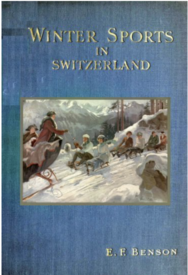

In [18]:
Image(filename='images/winter-sports-cover.png', width=150)

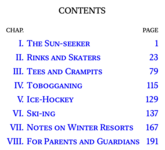

In [17]:
Image(filename="images/winter-sports-toc.png", width=150) 

Again, we use the web API to process the file.

In [14]:
filename = "example_files/winter-sports.epub"

with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=filename,
    )

request = shared.PartitionParameters(files=files, content_type='epub')

try:
    response = s.general.partition(request)
except SDKError as e:
    print(e)

INFO: Preparing to split document for partition.
INFO: Given file doesn't have '.pdf' extension, so splitting is not enabled.
INFO: Partitioning without split.
INFO: Successfully partitioned the document.


Let's checkout the response. Just like before but now we have a lot (716) elements.

In [15]:
elements = response.elements

element_types = set([type(e) for e in elements])

print("Elements Information")
pprint({
    "number": len(elements),
    "types": element_types,
})

print("\nElement #1 content")
pprint(elements[0], width=60, depth=2)


Elements Information
{'number': 716, 'types': {<class 'dict'>}}

Element #1 content
{'element_id': 'c2994d1baf27b22f630c8f044664879d',
 'metadata': {'category_depth': 1,
              'filename': 'winter-sports.epub',
              'filetype': 'application/epub',
              'languages': [...]},
 'text': 'The Project Gutenberg eBook of Winter Sports in '
         'Switzerland, by E. F. Benson',
 'type': 'Title'}


### Hierarchy in Elements

Notice in each element, we have two attributes that indicate the hierarchical structure of these elments. Namely,

- `element_id`
- `metadata/parent_id`

We can recover a Tree data structure from these two.

In [16]:
idx = 9
print(f"\nElement #{idx + 1} content\n")
pprint(elements[idx], width=60, depth=2)


Element #10 content

{'element_id': 'aa4b17534a6fb8c01a05440474d89f99',
 'metadata': {'filename': 'winter-sports.epub',
              'filetype': 'application/epub',
              'languages': [...],
              'parent_id': 'ec704441617fcfa0d3dbbcc2e9c5570a'},
 'text': '*** START OF THE PROJECT GUTENBERG EBOOK WINTER '
         'SPORTS IN SWITZERLAND ***',
 'type': 'UncategorizedText'}


### Recover Chapter detail

Here is an example. We can find the elements, that "belong" to each chapter titles.

If we know these "root nodes" we can find their children by transversing the tree!

In [17]:
chapters = [
    "THE SUN-SEEKER",
    "RINKS AND SKATERS",
    "TEES AND CRAMPITS",
    "ICE-HOCKEY",
    "SKI-ING",
    "NOTES ON WINTER RESORTS",
    "FOR PARENTS AND GUARDIANS",
]

Step 1: to get the element ID for these root nodes.

In [18]:
chapter_ids = {}
for element in elements:
    for chapter in chapters:
        e_text = element["text"]
        e_type = element["type"]
        if (chapter in e_text) and e_type == "Title":
            chapter_ids[element["element_id"]] = chapter
            break

In [19]:
chapter_ids

{'65af5da00154a2f526b43177bbad3189': 'THE SUN-SEEKER',
 '4e3f02ce1525ca1a197b5d5e9cd1953d': 'RINKS AND SKATERS',
 'c2f9b5a30cb07d9adaf5f390dc8e7564': 'TEES AND CRAMPITS',
 '67d58ab3aae6e41e9ce429dc4cbe5501': 'ICE-HOCKEY',
 'ea7faf4689009a3b72bf19dc10f29037': 'SKI-ING',
 'ea3feb77c48592d21a05386e68fde88e': 'NOTES ON WINTER RESORTS',
 '56c4ba79d33a505bb9b4480d7a5a4ce7': 'FOR PARENTS AND GUARDIANS'}

Step 2. Find children.

Now we find the childern IDs for each chapters.

(To better format the output, I limited the element size for each chapter to be <= 5.)

In [20]:
MAX_LENGTH = 5
chapter_to_id = {v: k for k, v in chapter_ids.items()}

children = {}
for chapter in chapters:
    children[chapter] = []
    parent_id = chapter_to_id[chapter]
    for e in elements:
        if e['metadata'].get("parent_id") == parent_id:
            children[chapter].append(e)
        if len(children[chapter]) >= MAX_LENGTH:
            break

pprint(children, depth=2)

{'FOR PARENTS AND GUARDIANS': [{...}, {...}, {...}, {...}, {...}],
 'ICE-HOCKEY': [{...}, {...}, {...}, {...}, {...}],
 'NOTES ON WINTER RESORTS': [{...}, {...}, {...}, {...}, {...}],
 'RINKS AND SKATERS': [{...}, {...}, {...}, {...}, {...}],
 'SKI-ING': [{...}, {...}, {...}, {...}, {...}],
 'TEES AND CRAMPITS': [{...}, {...}, {...}, {...}, {...}],
 'THE SUN-SEEKER': [{...}, {...}, {...}, {...}, {...}]}


## Ingesting Documents to VDB

Vector database are convient ways to store the embeddings and metadata for elements.

The embeddings can be used for semantic search.

The metdata can be used to aid hybrid search.

### Vector Database.

In this section we will use `chromadb` as the vectore database.

By default, `chromadb` use minilm-L6-v2 as the embedding model.

In [21]:
import chromadb

In [22]:
client = chromadb.PersistentClient(
    path="chroma_tmp",
    settings=chromadb.Settings(allow_reset=True),
)
client.reset()

INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


True

In [23]:
collection = client.create_collection(
    name="winter_sports",
    metadata={"hnsw:space": "cosine"}
)

### Ingesting Documents

The vector database [chromadb](https://www.trychroma.com/) automatically calculates the embeddings for us.

However, the calculation is performed on CPU by default and it is very slow. We can use GPU for much better performance. But this is another topic which will not include here.

In [24]:
for element in elements:
    parent_id = element["metadata"].get("parent_id")
    chapter = chapter_ids.get(parent_id, "")
    collection.add(
        documents=[element["text"]],
        ids=[element["element_id"]],
        metadatas=[{"chapter": chapter}]
    )

### Query the database

We can use the `peek` method to check out items in the database.

In [25]:
results = collection.peek(limit=3)
pprint(results["documents"])

['• You provide a full refund of any money paid by a user who notifies you in '
 'writing (or by e-mail) within 30 days of receipt that s/he does not agree to '
 'the terms of the full Project Gutenberg™ License. You must require such a '
 'user to return or destroy all copies of the works possessed in a physical '
 'medium and discontinue all use of and all access to other copies of Project '
 'Gutenberg™ works.',
 '[Image unavailable.]',
 'Each call must be skated at least twice, beginning once with the right foot '
 'and once with the left.']


We can use `query` method to perform semantic search.

We can use `where` parameter to filter out unwanted items.

In [26]:
result = collection.query(
    query_texts=["How many people are on a team?"],
    n_results=2,
    where={"chapter": "ICE-HOCKEY"},
)
pprint(result)

{'data': None,
 'distances': [[0.6024625301361084, 0.8077031970024109]],
 'documents': [['It is a wonderful and delightful sight to watch the speed and '
                'accuracy of a first-rate team, each member of which knows the '
                'play of the other five players. The finer the team, as is '
                'always the case, the greater is their interdependence on each '
                'other, and the less there is of individual play. Brilliant '
                'running and dribbling, indeed, you will see; but as '
                'distinguished from a side composed of individuals, however '
                'good, who are yet not a team, these brilliant episodes are '
                'always part of a plan, and end not in some wild shot but in a '
                'pass or a succession of passes, designed to lead to a good '
                'opening for scoring. There is, indeed, no game at which team '
                'play outwits individual brilliance so complete

## Chunking the Content

### Introduction

- Chunking Necessity: Vector databases need documents split into chunks for retrieval and prompt generation.
- Query Result Variability: The same query will return different content depending on how the document is chunked.
- Even Size Chunks: The easiest way is to split the document into roughly even size chunks. This can result in similar content getting split across chunks.

### Chunking by Atomic Elements

By identifying atomic elements, you can chunk by **combining** elements rather than splitting raw text.

- Results in more coherent chunks
- Example: combining content under the same section header into the same chunk.

We can use the `chunk_by_title` function to achieve this.

How is this done?

1. partitioning documents into atomic elements
2. combine elements until a **breaking condition** is satisfied.

What are the break conditions?

- elements are having a new title/section
- element similarity value exceeds a threshold
- element metadata (page) having a new value.

We need to experiment a bit to find the good stragety. Here is an example.

In [27]:
from unstructured.chunking.basic import chunk_elements
from unstructured.chunking.title import chunk_by_title
from unstructured.staging.base import dict_to_elements

elements = dict_to_elements(elements)
print(f"There are {len(elements)} elements ({type(elements[0])})")

There are 716 elements (<class 'unstructured.documents.elements.Title'>)


Now we apply the `chunk_by_title` function where the break condition is:

> Splits off into a new CompositeElement when a title is detected or if metadata changes, which
happens when page numbers or sections change. Cuts off sections once they have exceeded a
character length of max_characters.

In [28]:
chunks = chunk_by_title(
    elements,
    combine_text_under_n_chars=100,
    max_characters=3000,  # maximum number for a chunk
)

print(f"There are {len(chunks)} chunks after `chunk_by_title`")

There are 248 chunks after `chunk_by_title`


In [29]:
print(chunks[1])

Title: Winter Sports in Switzerland

Author: E. F. Benson

Illustrator: C. Fleming Williams

Photographer: Mrs. Aubrey Le Blond

Release date: August 23, 2019 [EBook #60153] Most recently updated: January 30, 2020


## Preprocessing PDFs and Images

### Introduction: DLD and ViT

Sometimes we need **visual** information to process the documents. Here we will use two techniques

- Document layout detection (DLD)
- Vision transformers (ViT): 

For the DLD approach, we use object detection model (typically, yolo) to draw bounding boxes.

1. vision detection: identify and classify bounding boxes
2. (optional) text extraction: to perform OCR within bounding boxes

For the ViT approach, We often use the document understanding transformer (DONUT) architecture ([arxiv paper](https://arxiv.org/abs/2111.15664)), where

- the image is passed to the transformer encoder, and the decoder generates the output.
- OCR is not needed
- We can train the model to output a valid JSON string. 

### Example

Now we will parse a document that looks like below.

The title should be

> A potent pair of atmospheric rivers ...

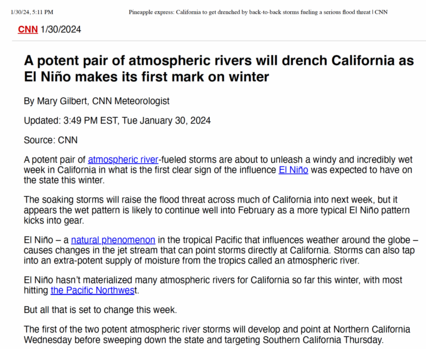

In [19]:
Image(filename="images/el_nino.png", width=300) 

### Parsing HTML (Pure Text, Local)

If we parse the HTML page directly, we get some results.

However, there are issus. Most notably, <font color="red">header/metadata content are recognised as the title.</font>

In [31]:
filename = "example_files/el_nino.html"
html_elements = partition_html(filename=filename)

for element in html_elements[:10]:
    if len(element.text) > 40:
        print(f"{element.category.upper(): <16}: {element.text[:40]} ...")
    else:
        print(f"{element.category.upper(): <16}: {element.text}")

UNCATEGORIZEDTEXT: CNN 1/30/2024
TITLE           : A potent pair of atmospheric rivers will ...
TITLE           : By Mary Gilbert, CNN Meteorologist
TITLE           : Updated: 3:49 PM EST, Tue January 30, 20 ...
TITLE           : Source: CNN
NARRATIVETEXT   : A potent pair of atmospheric river-fuele ...
NARRATIVETEXT   : The soaking storms will raise the flood  ...
NARRATIVETEXT   : El Niño – a natural phenomenon in the tr ...
NARRATIVETEXT   : El Niño hasn’t materialized many atmosph ...
NARRATIVETEXT   : But all that is set to change this week.


### Parsing PDF (Direct, Local)

The `fast` stragety from unstructured can parse the PDF file by working on the text directly.

However, there are issues. Most notablly, <font color="red">the title is wrong!</font>

In [32]:
from unstructured.partition.pdf import partition_pdf

filename = "example_files/el_nino.pdf"
pdf_elements = partition_pdf(filename=filename, strategy="fast")

for element in pdf_elements[:10]:
    if len(element.text) > 40:
        print(f"{element.category.upper(): <16}: {element.text[:40]} ...")
    else:
        print(f"{element.category.upper(): <16}: {element.text}")

INFO: pikepdf C++ to Python logger bridge initialized


HEADER          : 1/30/24, 5:11 PM
HEADER          : Pineapple express: California to get dre ...
HEADER          : CNN 1/30/2024
NARRATIVETEXT   : A potent pair of atmospheric rivers will ...
TITLE           : By Mary Gilbert, CNN Meteorologist
TITLE           : Updated: 3:49 PM EST, Tue January 30, 20 ...
TITLE           : Source: CNN
NARRATIVETEXT   : A potent pair of atmospheric river-fuele ...
NARRATIVETEXT   : The soaking storms will raise the ﬂood t ...
NARRATIVETEXT   : El Niño – a natural phenomenon in the tr ...


### Parsing PDF (DLD, API)

If we use DLD we see a great improvement over direct method.

For instance, the header are separated from the title.

In [33]:
with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=filename,
    )

req = shared.PartitionParameters(
    files=files,
    strategy="hi_res",
    hi_res_model_name="yolox",
)

try:
    resp = s.general.partition(req)
    dld_elements = dict_to_elements(resp.elements)
except SDKError as e:
    print(e)

INFO: Preparing to split document for partition.
INFO: Starting page number set to 1
INFO: Allow failed set to 0
INFO: Concurrency level set to 5
INFO: Splitting pages 1 to 2 (2 total)
INFO: Determined optimal split size of 2 pages.
INFO: Document has too few pages (2) to be split efficiently. Partitioning without split.
INFO: Successfully partitioned the document.


In [34]:
for element in dld_elements[:10]:
    if len(element.text) > 40:
        print(f"{element.category.upper(): <16}: {element.text[:40]} ...")
    else:
        print(f"{element.category.upper(): <16}: {element.text}")

HEADER          : 1/30/24, 5:11 PM
HEADER          : CNN 1/30/2024
HEADER          : Pineapple express: California to get dre ...
TITLE           : A potent pair of atmospheric rivers will ...
NARRATIVETEXT   : By Mary Gilbert, CNN Meteorologist
NARRATIVETEXT   : Updated: 3:49 PM EST, Tue January 30, 20 ...
NARRATIVETEXT   : Source: CNN
NARRATIVETEXT   : A potent pair of atmospheric river-fuele ...
NARRATIVETEXT   : The soaking storms will raise the ﬂood t ...
NARRATIVETEXT   : El Niño – a natural phenomenon in the tr ...


If we inspect the different categories, the PDF parser does a better job than the HTML!

In [35]:
import collections

html_categories = [el.category for el in html_elements]
collections.Counter(html_categories).most_common()

[('NarrativeText', 23), ('Title', 7), ('UncategorizedText', 1)]

In [36]:
dld_categories = [el.category for el in dld_elements]
collections.Counter(dld_categories).most_common()

[('NarrativeText', 28), ('Header', 6), ('Title', 4), ('Footer', 1)]

## Extracting Tables

### Introduction

We can use [table transformer](https://github.com/microsoft/table-transformer) to process tabular data, getting JSON response.

1. identify table location with a document layout model (bounding boxes)
2. run the table through the table transfoermer

We can also just use ViT to extract table content. Typically we get HTML source code back.

Finally we can also use rules--based OCR to process the table.

### Example

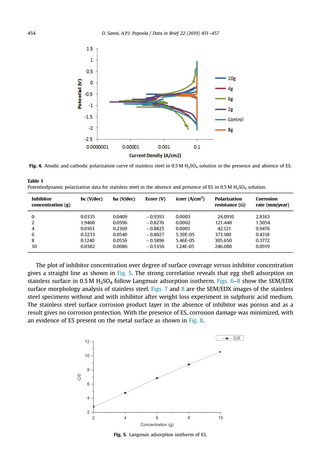

In [22]:
Image(filename="images/embedded-images-tables.png", width=250)

In [38]:
filename = "example_files/embedded-images-tables.pdf"

with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=filename,
    )

req = shared.PartitionParameters(
    files=files,
    strategy="hi_res",
    hi_res_model_name="yolox",
    skip_infer_table_types=[],
    pdf_infer_table_structure=True,  # This is important for tables
)

try:
    resp = s.general.partition(req)
    elements = dict_to_elements(resp.elements)
except SDKError as e:
    print(e)

INFO: Preparing to split document for partition.
INFO: Starting page number set to 1
INFO: Allow failed set to 0
INFO: Concurrency level set to 5
INFO: Splitting pages 1 to 1 (1 total)
INFO: Determined optimal split size of 2 pages.
INFO: Document has too few pages (1) to be split efficiently. Partitioning without split.
INFO: Successfully partitioned the document.


In [39]:
tables = [el for el in elements if el.category == "Table"]

In [40]:
tables[0].text

'Inhibitor Polarization Corrosion be (V/dec) ba (V/dec) Ecorr (V) icorr (AJcm?) concentration (g) resistance (Q) rate (mmj/year) 0.0335 0.0409 —0.9393 0.0003 24.0910 2.8163 1.9460 0.0596 .8276 0.0002 121.440 1.5054 0.0163 0.2369 .8825 0.0001 42121 0.9476 s NO 03233 0.0540 —0.8027 5.39E-05 373.180 0.4318 0.1240 0.0556 .5896 5.46E-05 305.650 0.3772 = 5 0.0382 0.0086 .5356 1.24E-05 246.080 0.0919'

In [41]:
from IPython.core.display import HTML

table_html = tables[0].metadata.text_as_html
HTML(table_html)

Inhibitor concentration (g),be (V/dec),ba (V/dec),Ecorr (V),icorr (AJcm?),Polarization resistance (Q),Corrosion rate (mmj/year)
,0.0335,0.0409,—0.9393,0.0003,24.0910,2.8163
NO,1.9460,0.0596,—0.8276,0.0002,121.440,1.5054
,0.0163,0.2369,—0.8825,0.0001,42121,0.9476
s,03233,0.0540,—0.8027,5.39E-05,373.180,0.4318
,0.1240,0.0556,—0.5896,5.46E-05,305.650,0.3772
= 5,0.0382,0.0086,—0.5356,1.24E-05,246.080,0.0919


### Table Summarisation

Finally, we can use langchain to summarize the table. Here we use a local LLM served by Ollama instead of OpenAI.

(I use langchian because it was in the tutorial.)

In [42]:
from langchain_community.llms import Ollama
from langchain_core.documents import Document
from langchain.chains.summarize import load_summarize_chain

In [43]:
LLM_MODEL = "gemma2"
llm = Ollama(model=LLM_MODEL)

In [44]:
chain = load_summarize_chain(llm, chain_type="stuff")
result = chain.invoke([Document(page_content=table_html)])

In [45]:
print(result['output_text'].strip())

The table presents electrochemical data for a material's corrosion behavior under various inhibitor concentrations. 

Key parameters measured include:

* **Inhibitor concentration:**  Ranges from 0 to 5 g.
* **be and ba (V/dec):** Polarization resistance coefficients related to anodic and cathodic reactions.
* **Ecorr (V):** Corrosion potential.
* **icorr (A/cm²):** Corrosion current density.
* **Polarization resistance (Q):** Resistance to electrochemical polarization.
* **Corrosion rate (mm/year):** Material degradation rate.

The data reveals that increasing inhibitor concentration generally decreases corrosion current and rate, suggesting an inhibitory effect on the material's corrosion process.


## Building RAG Bot

### Overview

```{mermaid}
flowchart LR;
    h[*.html];
    s[*.pptx];
    p[*.pdf];
    q([user query]);
    x[prompt];
    llm{{LLM}};
    vdb[(Vector\nDatabase)]
    h --> vdb;
    s --> vdb;
    p --> vdb;
    q --> vdb --> x;
    q --> x --> llm;
```

### Example

Our documents including a paper (PDF), a slid (PPTX) and a mardown file (README.md).

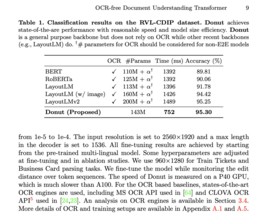

In [23]:
Image(filename='images/donut_paper.png', width=200)

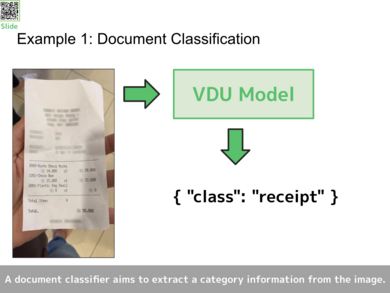

In [24]:
Image(filename='images/donut_slide.png', width=200) 

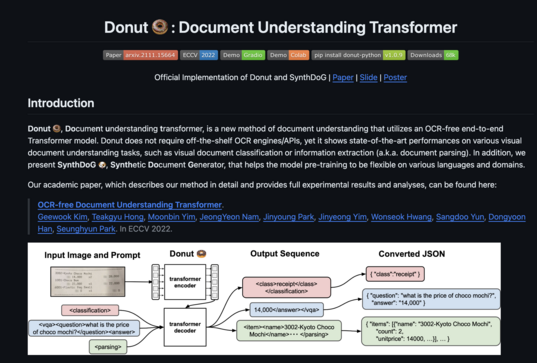

In [25]:
Image(filename='images/donut_readme.png', width=200) 

### Process PDF

In [49]:
filename = "example_files/donut_paper.pdf"

with open(filename, "rb") as f:
    files=shared.Files(
        content=f.read(),
        file_name=filename,
    )

req = shared.PartitionParameters(
    files=files,
    strategy="fast",
    pdf_infer_table_structure=True,
    skip_infer_table_types=[],
)

try:
    resp = s.general.partition(req)
    pdf_elements = dict_to_elements(resp.elements)
except:
    ...

INFO: Preparing to split document for partition.
INFO: Starting page number set to 1
INFO: Allow failed set to 0
INFO: Concurrency level set to 5
INFO: Splitting pages 1 to 29 (29 total)
INFO: Determined optimal split size of 6 pages.
INFO: Partitioning 4 files with 6 page(s) each.
INFO: Partitioning 1 file with 5 page(s).
INFO: Partitioning set #1 (pages 1-6).
INFO: Partitioning set #2 (pages 7-12).
INFO: Partitioning set #3 (pages 13-18).
INFO: Partitioning set #4 (pages 19-24).
INFO: Partitioning set #5 (pages 25-29).
INFO: HTTP Request: POST https://api.unstructured.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructured.io/general/v0/general "HTTP/1.1 200 OK"
ERROR: Failed to send request for page 7
INFO: Successfully partitioned the document.


### Filter Unwanted Items

- reference section in the paper
- the header in each page 

In [50]:
print(len(pdf_elements), "-->", end=" ")
pdf_elements = [el for el in pdf_elements if el.category != "Footer"]
print(len(pdf_elements))

39 --> 34


### Process PPTX and Markdown

In [51]:
from unstructured.partition.md import partition_md


filename = "example_files/donut_slide.pptx"
pptx_elements = partition_pptx(filename=filename)

filename = "example_files/donut_readme.md"
md_elements = partition_md(filename=filename)

### Prepare Vector Database

In [52]:
elements = chunk_by_title(pdf_elements + pptx_elements + md_elements)
len(elements)

97

In [53]:
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings


EMBEDDING_MODEL = "all-minilm"
embeddings = OllamaEmbeddings(model=EMBEDDING_MODEL)

In [54]:
documents = []
for element in elements:
    metadata = element.metadata.to_dict()
    del metadata["languages"]
    metadata["source"] = metadata["filename"]
    for key, item in metadata.items():
        if isinstance(item, list):
            metadata[key] = "/".join(item)
    documents.append(
        Document(page_content=element.text, metadata=metadata)
    )

In [55]:
vectorstore = Chroma.from_documents(documents, embeddings)

INFO: Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


### Interact with the Vector Database

In [56]:
from langchain_community.llms import Ollama
from langchain.prompts.prompt import PromptTemplate
from langchain.chains import ConversationalRetrievalChain, LLMChain
from langchain.chains.qa_with_sources import load_qa_with_sources_chain

LLM_MODEL = "gemma2"
llm = Ollama(model=LLM_MODEL)

retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 6}
)

In [62]:
template = """You are an AI assistant for answering questions \
about the Donut document understanding model.
You are given the following extracted parts of a long document \
and a question. Provide a conversational answer. \
If you don't know the answer, just say "Hmm, I'm not sure." \
Don't try to make up an answer.
If the question is not about Donut, politely inform them that \
you are tuned to only answer questions about Donut.
Question: {question}
=========
{context}
=========
Answer in Markdown:"""

prompt = PromptTemplate(
    template=template, input_variables=["question", "context"]
)

doc_chain = load_qa_with_sources_chain(llm, chain_type="map_reduce")

question_generator_chain = LLMChain(llm=llm, prompt=prompt)

qa_chain = ConversationalRetrievalChain(
    retriever=retriever,
    question_generator=question_generator_chain,
    combine_docs_chain=doc_chain,
)

In [58]:
qa_chain.invoke({
    "question": "How does Donut compare to other document understanding models?",
    "chat_history": []
})["answer"]

Token indices sequence length is longer than the specified maximum sequence length for this model (1837 > 1024). Running this sequence through the model will result in indexing errors


'Donut achieves state-of-the-art scores with reasonable speed and efficiency. It also shows superior accuracy compared to other models with significantly faster inference speed.  \nSOURCES: donut_slide.pptx, donut_readme.md \n\n\n'

### Query by Specifying Source

In [59]:
filter_retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1, "filter": {"source": "donut_readme.md"}}
)

In [60]:
filter_chain = ConversationalRetrievalChain(
    retriever=filter_retriever,
    question_generator=question_generator_chain,
    combine_docs_chain=doc_chain,
)

In [61]:
filter_chain.invoke({
    "question": "How do I classify documents with DONUT?",
    "chat_history": [],
    "filter": filter,
})["answer"]

'You classify documents with DONUT by using the  `{"class" : {class_name}}` format, where `{class_name}` is the name of the document\'s class. For example, `{"class" : "scientific_report"}`. \n\nSOURCES: donut_readme.md \n'